In [1]:
from adam import ADAM
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
import numpy as np
from qiskit.quantum_info import Statevector
from math import log

In [2]:
# size of training data set
training_size = 100
# dimension of data sets
n = 4
from sklearn import datasets
from sklearn import preprocessing
iris = datasets.load_iris()
# load iris and normalise
x = preprocessing.normalize(iris.data)
x1_train = x[0:49, :] # class A
x2_train = x[50:99, :] # class B
training_input = {'A':x1_train, 'B':x2_train}
class_labels = ['A', 'B']

In [3]:
sv = Statevector.from_label('0' * n)

In [4]:
def final_circuit(circuit, data, params):
    for i in range(n):
        circuit.h(i)
        circuit.rz(data[i],i)
        circuit.ry(params[i], i)
        
    circuit.cx(0,3)
    circuit.cx(1,2)
    
    circuit.barrier()
    for i in range(n):
        circuit.rz(data[i],i)
        circuit.ry(params[i+4], i)
        
    circuit.cx(0,3)
    circuit.cx(1,2)
    
    circuit.barrier()
    for i in range(n):
        circuit.rz(data[i],i)
        circuit.ry(params[i+8], i)

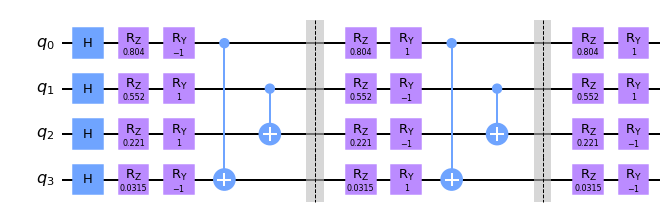

In [5]:
cir = QuantumCircuit(4)
final_circuit(cir, x[0], [-1,1,1,-1,1,-1,-1,1,1,1,-1,-1])
cir.draw('mpl')

In [6]:
def assign_label(bit_string, class_labels):
    hamming_weight = sum([int(k) for k in list(bit_string)])
    is_odd_parity = hamming_weight & 1
    if is_odd_parity:
        return class_labels[1]
    else:
        return class_labels[0]

def return_probabilities(counts, class_labels):
    shots = sum(counts.values())
    result = {class_labels[0]: 0,
              class_labels[1]: 0}
    for key, item in counts.items():
        label = assign_label(key, class_labels)
        result[label] += counts[key]/shots
    return result

def classify(x_list, params, class_labels):
    qc_list = []
    for x in x_list:
        circuit = QuantumCircuit(n)
        circ_ = final_circuit(circuit, x, params)
        qc = sv.evolve(circuit)
        qc_list += [qc]
    probs = []
    for qc in qc_list:
        counts = qc.probabilities_dict()
        prob = return_probabilities(counts, class_labels)
        probs += [prob]
    return probs


def CrossEntropy(yHat, y):
    if y == 'A':
      return -log(yHat['A'])
    else:
      return -log(1-yHat['A'])


def cost_function(training_input, class_labels, params, shots=100, print_value=False):
    # map training input to list of labels and list of samples
    cost = 0
    training_labels = []
    training_samples = []
    for label, samples in training_input.items():
        for sample in samples:
            training_labels += [label]
            training_samples += [sample]

    # classify all samples
    probs = classify(training_samples, params, class_labels)

    # evaluate costs for all classified samples
    for i, prob in enumerate(probs):
        # cost += cost_estimate_sigmoid(prob, training_labels[i])
        cost += CrossEntropy(yHat=prob, y=training_labels[i])
    cost /= len(training_samples)

    # return objective value
    #print(cost)
    return cost


# setup the optimizer
optimizer = ADAM(maxiter=100, lr=0.1)

# define objective function for training
objective_function = lambda params: cost_function(training_input, class_labels, params, print_value=True)

d = 12  # num of trainable params
for i in range(7,100,1):
    print(i)
    np.random.seed(i)
    # randomly initialize the parameters
    init_params = np.random.uniform(-1,1,12)
    print(init_params)
    # train classifier
    init_params = np.random.uniform(-1,1,12)
    opt_params, value, _, loss = optimizer.optimize(len(init_params), objective_function, initial_point=init_params)
    print(loss)
    print(opt_params)
    # print results
    f1 = 'Layer3Easy4q/quantum_loss_easy_layer34q_%d.npy' %i
    f2 = 'Layer3Easy4q/opt_params_easy_layer34q_%d.npy'%i
    np.save(f2, opt_params)
    np.save(f1, loss)

7
[-8.47383421e-01  5.59837584e-01 -1.23181537e-01  4.46930356e-01
  9.55979024e-01  7.69917408e-02  2.24092732e-03 -8.55897733e-01
 -4.63122040e-01 -2.34998349e-04  3.58459992e-01  6.07478072e-01]
[0.6133931299545422, 0.5678897693626569, 0.5309074771362917, 0.5069928554316251, 0.4937802703873271, 0.4831209607700363, 0.47086989644117144, 0.4564706125042996, 0.4415859444571306, 0.4289019773603609, 0.4201432325603582, 0.41504784162262115, 0.41177877954427033, 0.40865926834401906, 0.4054357271392322, 0.40292957475786334, 0.40194945418801664, 0.40237517397244665, 0.40306827634000353, 0.40275548302735137, 0.4010086190796359, 0.3984005065045162, 0.3959145940047682, 0.39418435056343615, 0.3930846169942005, 0.3919763512761814, 0.39033605861806825, 0.38814351960781934, 0.3857680046632632, 0.3835661869394348, 0.3815871139503533, 0.3796113785973273, 0.3773726555297393, 0.37477669293607363, 0.3720487222319295, 0.3696131455864702, 0.3677635640752476, 0.3664789326849094, 0.3655770365495878, 0.364988

[0.665706973553199, 0.6486485180709675, 0.6286688420039874, 0.6096167008006972, 0.5910609551899492, 0.5716704730437117, 0.5514061298997096, 0.5303631446866217, 0.5094442367718393, 0.4892175908225458, 0.46916839570270813, 0.4483469729554171, 0.42735962047160564, 0.40952885646631, 0.3986956266643707, 0.39542069120855644, 0.3970447753860664, 0.40054870328995085, 0.40357421523140763, 0.40490297040471146, 0.40482915527491053, 0.40450443368559996, 0.4042947938062988, 0.4031621223221319, 0.4003455441292524, 0.3964028557989546, 0.39236329486086285, 0.3889951537163419, 0.38662919495832027, 0.38504091928815876, 0.3837399597293124, 0.3823272853631363, 0.3804526799421452, 0.37792595093671644, 0.37500393178796965, 0.3721993158732876, 0.3699639256233171, 0.368574123898628, 0.3679578467761301, 0.36777360259724906, 0.3677419679938422, 0.36766886098767526, 0.36739740398139203, 0.3668980007069767, 0.3662352291812553, 0.3655470106621073, 0.36502511052667497, 0.3647528989471265, 0.36469351755654206, 0.364

[0.6632419582661905, 0.653539936410184, 0.6459842558707161, 0.6372261988220514, 0.6267210395276284, 0.615759976617432, 0.6053689517052624, 0.5959599986136408, 0.5875457604038096, 0.5797151791278414, 0.5717392948577691, 0.5636036569243141, 0.5555544063433796, 0.5469041900918818, 0.5367817535782132, 0.5250852377771623, 0.5127381527696488, 0.5016724738058185, 0.4938579551182625, 0.4897714364066512, 0.48811277554365406, 0.4871913214881292, 0.48584284339992245, 0.48353649876335086, 0.4802633522867932, 0.47638326112654955, 0.47236489843724333, 0.46849222020423603, 0.46481925283694986, 0.4612870096754876, 0.45770639846186706, 0.4538746100003322, 0.44998895694227115, 0.44670504362477276, 0.44444002388523773, 0.443116915904311, 0.4427331925815814, 0.443324288589177, 0.44434832650095, 0.4448871382589865, 0.4445209592121443, 0.44363010319855284, 0.4429567156498717, 0.44292133372239534, 0.44322687647695835, 0.4432448529620745, 0.4427026412787837, 0.4418092554478943, 0.4409957187763894, 0.440662680

[0.673646797460052, 0.6554604660899168, 0.6203423965871255, 0.5716188596715683, 0.5230691056665268, 0.4881752312699381, 0.46344479082619155, 0.44143800263377625, 0.422224565305191, 0.40903674847321864, 0.40167855764379107, 0.39699594786033127, 0.3935640646788267, 0.39054503855748235, 0.3866984174496309, 0.3819351030340212, 0.377673800346147, 0.37534914981362033, 0.37530609381775076, 0.3764935775444779, 0.3771867147435584, 0.37644364480558473, 0.37452048722772924, 0.3723097290928303, 0.37066337688810447, 0.36991705993681595, 0.3698300801476001, 0.3699577715081955, 0.37000421787360505, 0.3698446304799945, 0.3694180023154032, 0.36870871199892485, 0.3678208248592504, 0.36701889094872087, 0.36659922203813267, 0.3666282099883491, 0.3668231962346535, 0.3667698524873356, 0.36628352152787524, 0.3655528942282263, 0.364954969662881, 0.36473471159764603, 0.3648335848162409, 0.3650054557670356, 0.36506636517507146, 0.36500589735353445, 0.3649018487315267, 0.3648052344655912, 0.36472247044029615, 0.

[0.6248895809037629, 0.6049009721770533, 0.5828654132384824, 0.5559518915736165, 0.5246124223485147, 0.4913490247831198, 0.46033293622461136, 0.436143064488562, 0.42098786669704175, 0.4123737572583188, 0.404895786088108, 0.3957041745342317, 0.38574667730306933, 0.37769022475628594, 0.3741589065498282, 0.3761180423039173, 0.3815644040732709, 0.3864769997093359, 0.388163671262658, 0.38720614691907, 0.38575694317114867, 0.3847697634383327, 0.3835599743575791, 0.3815080012933192, 0.37881233526215263, 0.37605309860881514, 0.37370352595108186, 0.3719109334830904, 0.37053451306697416, 0.36935531968498425, 0.36829028359616894, 0.3674651179626106, 0.36709898468697627, 0.36729276885685824, 0.36789512726370605, 0.36854755598593003, 0.3688737983155489, 0.36868808734778585, 0.3680872456925161, 0.3673702691224389, 0.3668418435039997, 0.36662930397148374, 0.3666320873274988, 0.3666305184285137, 0.3664619864406675, 0.36612775547016324, 0.3657647417717224, 0.3655258668879284, 0.36547032435133964, 0.365

[0.6912085572534548, 0.6939079429919071, 0.6986675040564124, 0.7012116983126148, 0.7006589821017788, 0.697538394976058, 0.6928027203168502, 0.68714550641435, 0.6814380785941062, 0.6770069260672927, 0.673931581771534, 0.6690378252348864, 0.6595054419237765, 0.6478083410185197, 0.6388058622996531, 0.632881826015432, 0.6257851192250177, 0.6166616110799961, 0.60841831321964, 0.6034005848287619, 0.601350363615842, 0.6003924002431369, 0.5992598512644338, 0.5980365967330282, 0.5971901830725079, 0.5965451249030383, 0.5954932154198579, 0.5939236131945876, 0.5923169574890653, 0.5912319266441532, 0.5908710750075079, 0.5910123054120298, 0.5912772967839149, 0.5914118025075302, 0.591305531200845, 0.5908463597545874, 0.5898656758961758, 0.5882747987235941, 0.5862242787991846, 0.5840722993918809, 0.5821823559906407, 0.5807419962343686, 0.579731832786406, 0.5790074678113653, 0.5783842603269287, 0.577691458146018, 0.576834653952786, 0.5758526127564707, 0.5748932599664429, 0.5740961644538704, 0.573473085

[0.683322949597168, 0.6772687120033776, 0.6703319685175445, 0.6564587491042314, 0.6372488440277481, 0.6147899850900657, 0.591906541769077, 0.5718762218925303, 0.5562558215562203, 0.5425276752368208, 0.5275953074199805, 0.511417461170635, 0.495583206656328, 0.48173421818413387, 0.47113335342004964, 0.46409134135622193, 0.4594613698754046, 0.4555061126089184, 0.4513441704284951, 0.4471837563963946, 0.44372374610447, 0.44157799005433396, 0.44096766867641024, 0.44176337186986414, 0.443446247493007, 0.4450506906890843, 0.44558713242218395, 0.44474617880849715, 0.4429601622551173, 0.4406983148360918, 0.4379155590450641, 0.43419447959768387, 0.42926713858357557, 0.42338605174420163, 0.4172748558484935, 0.41176119888053986, 0.40747717946134165, 0.4047296487520806, 0.40337270413553505, 0.40288621989786916, 0.4027136456708239, 0.4023636767198049, 0.401264589801505, 0.39889996040852205, 0.3952234250443304, 0.39082557347888225, 0.3866772466006367, 0.38360228084238196, 0.3818026572064025, 0.3808153

[0.684716048981086, 0.6758506950910845, 0.6571750855307861, 0.6275114735176218, 0.5920269898318297, 0.5550226669015893, 0.5172906299883566, 0.4823148707697586, 0.45371542726052716, 0.4314013570799304, 0.4131999651146884, 0.3996477219012675, 0.3923849343642583, 0.39099724397483543, 0.3927091413820944, 0.3948635923096325, 0.3958056385093478, 0.3947031111043114, 0.3920629900341675, 0.38942005838640387, 0.3878203978349967, 0.38683326961415415, 0.3855176663334211, 0.3832737671469551, 0.37983810543935914, 0.3756047397367718, 0.37166584603217, 0.36897673836172973, 0.36775587781992886, 0.3676338909879206, 0.36812594054275793, 0.3688496845481444, 0.36953809076792943, 0.3700279003919595, 0.3702488245428874, 0.37015972807379666, 0.3697172677989192, 0.3689860805464766, 0.3682270158726451, 0.36771716517275244, 0.3674802989130379, 0.36730876779953525, 0.3670229723955292, 0.3666123288007235, 0.3661737906103472, 0.36582070761233987, 0.36563624300547337, 0.36561989129165323, 0.36568264560093094, 0.3657

[0.6159937872358898, 0.5633522892032863, 0.5246960490581424, 0.5026108173506865, 0.4932858498898675, 0.4892340607168063, 0.48453628294255885, 0.47666463307007395, 0.4651896850856261, 0.4507742459745763, 0.43510097791400787, 0.42097083853510087, 0.41122860899655006, 0.406754580487748, 0.40608137245784615, 0.40711572522056505, 0.4078016261012784, 0.4063909746426451, 0.40215211430787606, 0.3957590364616796, 0.38892666116906155, 0.38353536477204225, 0.3806385483049276, 0.379857684876846, 0.37979801972364885, 0.3790935223811094, 0.3770769382059856, 0.3739626483499471, 0.37062460220767246, 0.36804001101045053, 0.36678850151385856, 0.36688265868652836, 0.3678458042434056, 0.3689235665222079, 0.3694419608642023, 0.36916358077610817, 0.3683652018253729, 0.36758862762579003, 0.3672453690384268, 0.36733968007470685, 0.36753361447208777, 0.36749392803823466, 0.36716448664173645, 0.36673578588671185, 0.36642041971224426, 0.366274316354887, 0.3661981655283786, 0.36605514518798477, 0.3657720588267506

[0.6574278298384694, 0.6146882968758893, 0.568833783045011, 0.5299832608904576, 0.5090875514840847, 0.5058873965081757, 0.5094128824268088, 0.5118575962438586, 0.5110269785383008, 0.5074322419984522, 0.5025954717774666, 0.4975237730965555, 0.492041940969914, 0.48597118821281743, 0.4801285326355253, 0.47572645189457363, 0.4732783287509375, 0.47214094136227747, 0.47112004345759295, 0.4694704609159038, 0.46725566031306776, 0.46500769521734114, 0.4632097165101378, 0.4619284387800824, 0.4607753393909502, 0.4592299487623286, 0.45704592601387994, 0.45437183015602967, 0.45155508459717925, 0.44887841962914554, 0.4464405786458545, 0.44420808858840594, 0.4421270639988502, 0.4401756570793175, 0.43832660799993206, 0.4364833754267117, 0.43448589563237044, 0.43220528369714334, 0.4296342338944449, 0.42687286612454606, 0.4240255993029942, 0.4211141360254193, 0.4180808942927849, 0.414859322768304, 0.41143333687666345, 0.4078440076734697, 0.40416644951225045, 0.40049234629963876, 0.39691799321007837, 0.3

[0.5832292964103585, 0.5475410153724812, 0.5227964141607969, 0.5066966378198005, 0.49547561186957084, 0.4866108945035666, 0.47945020601215116, 0.4741705711047101, 0.4714880166607906, 0.47165795728706594, 0.47366398405927307, 0.47585411352502444, 0.47723649968032483, 0.4775708711348201, 0.4768665357382752, 0.4753244541923156, 0.47329504657355714, 0.470986684926306, 0.4683525950125925, 0.4652787892348567, 0.46174306640128676, 0.4578460308452835, 0.45386809830118113, 0.4502337160448388, 0.4472804318846468, 0.44512797728801107, 0.443739519121934, 0.44294824160831087, 0.4425459891915355, 0.44242061630297275, 0.4424897276496314, 0.44264114282248995, 0.44276922602151997, 0.4427606563655334, 0.4425613516642968, 0.4422119554540529, 0.4417724731251546, 0.4413167459020971, 0.4409038167186943, 0.44056839439229656, 0.44037187577952347, 0.44035096417560177, 0.4404759719245242, 0.44065968219657536, 0.44078575733858477, 0.44079709737595607, 0.4407067390808566, 0.4405583522850392, 0.4403840070569721, 0

[0.6939194496404835, 0.6765222930053819, 0.6713085829340203, 0.6637985978627047, 0.6531990898337622, 0.6403482790463783, 0.6235534037726901, 0.6029645478017742, 0.5822135568303954, 0.5636898006950622, 0.5452436002454987, 0.5269612160493754, 0.5111256887885604, 0.49963854860402396, 0.49249949104331175, 0.48776787348322226, 0.48236666556591407, 0.4740299064558001, 0.46282093372139127, 0.4500740541123982, 0.4370278117768377, 0.4243420495578102, 0.4125788668623999, 0.4030331766078174, 0.3974880215476724, 0.3960178875271284, 0.3959438516404452, 0.39459816625569055, 0.39130002473065506, 0.38687267883410126, 0.38267432680067626, 0.3797124176940391, 0.37803197075025996, 0.37688987646106453, 0.3756047008744485, 0.37406336267667184, 0.3725126403183602, 0.3711604530071615, 0.3700369376865592, 0.3691364911546657, 0.3685544025269546, 0.36839196095532245, 0.3685633917542518, 0.3687933051064786, 0.36883120061926195, 0.36863729234899856, 0.3683529406044758, 0.36811480558572657, 0.3679139656518518, 0.3

[0.7077845444111811, 0.6827937588051616, 0.6787855167893654, 0.6751584121401532, 0.6604222613422763, 0.638665361775278, 0.6174022001394698, 0.6017283724223388, 0.5927476856051331, 0.5889523743652652, 0.5881803344558446, 0.588537975548766, 0.5885922703406701, 0.5875826754645146, 0.5855804069691493, 0.5832304485898027, 0.5812228380811573, 0.5798129991288627, 0.5787176711278383, 0.5775571211242497, 0.576316466756797, 0.5752382218652167, 0.5744146731636647, 0.5736547777654778, 0.5727692445952801, 0.5718581888318899, 0.5712088854526275, 0.5709534404805968, 0.5709068932846545, 0.5707553292250521, 0.5703364609337738, 0.5697008392393514, 0.5689723811117761, 0.5682246302820276, 0.5674844030507543, 0.566793235251329, 0.5662167981684114, 0.5657842453979984, 0.5654281619479907, 0.5650194837841833, 0.5644925587778818, 0.5639119703699181, 0.563385198082524, 0.5629297147860524, 0.5624584774594852, 0.5618890475922099, 0.5612324211093308, 0.5605719278064567, 0.5599930735942211, 0.5595506883802425, 0.55

[0.6264099431279684, 0.5854486303209049, 0.5480208329796522, 0.5156410072073779, 0.48289749884545896, 0.4520112838407715, 0.428234264883129, 0.41298413412592583, 0.4036767529402615, 0.3961835743738807, 0.3890897555825848, 0.38398341766238964, 0.38184264789046685, 0.3813224525012287, 0.3805765951585698, 0.3790623856264835, 0.3775293670690364, 0.3771146188130781, 0.3781960783713897, 0.37981133461885386, 0.380472016248742, 0.37951374716509967, 0.3774378520968329, 0.37528123048083994, 0.37383378067566225, 0.37321726664755955, 0.37298916262194887, 0.37260693788076715, 0.3718191796495729, 0.3707057167457021, 0.3694882619207383, 0.36837544613841766, 0.36754904467166566, 0.3671832788019004, 0.36735903482218174, 0.36792888549104935, 0.36853413537168606, 0.36883284559159063, 0.3687286339688188, 0.36836858537773015, 0.367947130623465, 0.3675495129004095, 0.3671694706067882, 0.3668097966669938, 0.36651128346142275, 0.36629405550080874, 0.36612065144334033, 0.36594650841780607, 0.3657894695060504, 

[0.6306311643697078, 0.6014748700321271, 0.578747044570224, 0.561522290206867, 0.5485947074458624, 0.5345984742111184, 0.5176397121964199, 0.49921942920671397, 0.4811440419278557, 0.4641757174629232, 0.4483709236321621, 0.434568303928582, 0.42455680666141704, 0.41926063698007077, 0.4170375781525003, 0.41480423809688916, 0.41067424595307367, 0.4047155685955409, 0.3981105373246536, 0.3921699632817921, 0.3876181185139832, 0.3842869654100272, 0.38157072862121433, 0.3792066855181607, 0.3774345936901556, 0.3764655265647866, 0.37597357417777166, 0.37525753623213465, 0.37391225460054, 0.3721918205773695, 0.3707107643658024, 0.36988017579441607, 0.36959870137634454, 0.3694669301739023, 0.36925838637663305, 0.3690647700313015, 0.3690147276447331, 0.3690079793153875, 0.36882799211131495, 0.36844244522907127, 0.3680374939126264, 0.36775335542813425, 0.3675111437279395, 0.3671730604058582, 0.36677492766817377, 0.3664741919721456, 0.36631626848812826, 0.3661846266815322, 0.3659927313467503, 0.365798

[0.6747510782856504, 0.6593419785520757, 0.6466562388211755, 0.6322311800608994, 0.6128429302710962, 0.587964124088928, 0.5605461436958699, 0.5362370238750693, 0.5177015663958597, 0.5018507693634533, 0.48625634989652755, 0.4711743375233962, 0.4579580928739759, 0.4467710178942053, 0.43628145727259876, 0.42486628023443035, 0.4121628961938652, 0.39990061276618993, 0.3909663911384408, 0.38644139023746055, 0.38468903093950313, 0.38471198954923536, 0.38669858006616964, 0.38931544202395163, 0.38973943432487557, 0.38643678315896113, 0.3802110614099834, 0.3733690114591711, 0.36824927739466995, 0.36606337894352126, 0.3665677796609389, 0.36855833220843354, 0.37066062719336984, 0.37190412862499256, 0.3719528085196676, 0.37104204373708166, 0.3697306334137133, 0.3686013685082498, 0.3680131261499741, 0.3679849379954525, 0.36825650814004374, 0.36847291495690654, 0.36836579265340275, 0.3678466965328868, 0.3670097823880188, 0.36606916039642295, 0.36526231755855054, 0.36476059654111476, 0.364619922822272

[0.6865642625503235, 0.6731114977705275, 0.651946167353648, 0.6190902938216497, 0.5762489265424905, 0.5297819302364218, 0.4872059603124887, 0.4538941468165218, 0.4307786027549988, 0.41678493820437923, 0.4097146371560076, 0.40696754700862153, 0.407180949499304, 0.4094545103175923, 0.4115425953565723, 0.4113774277234896, 0.4084484299746835, 0.40301568830763107, 0.3956222783278325, 0.38731673712036757, 0.379574421842603, 0.37372060837610893, 0.3705259177150879, 0.37014482447184927, 0.37208985075332823, 0.37511284230338143, 0.37734930721058724, 0.37731083181288816, 0.37495331684668953, 0.37159351022845394, 0.3688082769575367, 0.3673356362800597, 0.3668646886191134, 0.3667192168122314, 0.36654134864813914, 0.36640027112363704, 0.36652519460335403, 0.36699632315738084, 0.36759544340259476, 0.3679076130935918, 0.36760439969136105, 0.36669688775255027, 0.365560480690068, 0.3647036697290479, 0.364449493029616, 0.36476020625239, 0.3653156448700003, 0.3657499079166229, 0.36585300243597746, 0.3656

[0.6777316117968344, 0.6599724215357762, 0.645010383428361, 0.6334213084600313, 0.6219194719280108, 0.6126630457031899, 0.6073166938990219, 0.6038421884325852, 0.600106133254049, 0.5961074396712432, 0.5924629356330907, 0.5890234857266637, 0.5850063484759505, 0.5796499070355708, 0.5723718198280807, 0.5626139251523068, 0.5500848316576217, 0.5354167461684428, 0.520548447453346, 0.507459066219082, 0.4957089399139686, 0.48383576105041937, 0.4720628896807306, 0.4605910013659254, 0.44881843167593816, 0.4372199289330304, 0.42800738174469094, 0.4235257613684095, 0.42337761291147613, 0.424077551818246, 0.4228312327664521, 0.4193079924111162, 0.41468154521894607, 0.4103567299978377, 0.40708014868180126, 0.4047159029087263, 0.4027156543695025, 0.4007098693626221, 0.39873874945456084, 0.3972693804889723, 0.39701117603875735, 0.3982323072542528, 0.40005989746242177, 0.40105322345270417, 0.40074802903251594, 0.40002908617370675, 0.39987151262321613, 0.40021613503565684, 0.4002825143717601, 0.39959009

[0.695260156832672, 0.6942436187148572, 0.6948611621267673, 0.6915008453640575, 0.6842075826531607, 0.6749403333277664, 0.665863167119349, 0.6559152518594733, 0.6418459348735637, 0.6242613166500153, 0.6062589043958841, 0.5893662731286516, 0.5735401192456042, 0.5589640853605, 0.5458836441442269, 0.5339571622573942, 0.5226385513974333, 0.5117267066068787, 0.5015775315534252, 0.4929327887879492, 0.48651600456671196, 0.48257783649774255, 0.4806997970010936, 0.48014244876253653, 0.48028998856668303, 0.4808071519322638, 0.4816311539354191, 0.48277916274017063, 0.4840210084103068, 0.484808171269323, 0.484638082979692, 0.4833407390617305, 0.4809998698246455, 0.4778901093675083, 0.47449221502509886, 0.4712724812703044, 0.46842175800467833, 0.46587344952876775, 0.4635411245921384, 0.4614811263046046, 0.45984064396151897, 0.45871982104231174, 0.4580761812752253, 0.45770391508394115, 0.45731138105084673, 0.45665739915517495, 0.45561994711267506, 0.4541516824965804, 0.4522344307390426, 0.4499304898

[0.733030245754539, 0.7076556652991921, 0.6965540288636448, 0.6916821587592384, 0.6885546825913293, 0.6905754074944652, 0.699725685598418, 0.6985956674856161, 0.6902199550361905, 0.6828097274206428, 0.678694290843131, 0.676790039443507, 0.6752214223381061, 0.6720292089364135, 0.6658538549061612, 0.6570366398317082, 0.6483063182217409, 0.6431569037852168, 0.641225801119514, 0.6381103874638957, 0.6324776535222323, 0.6268660654387301, 0.6234951157380544, 0.621849241833743, 0.6197120257115638, 0.6157929623330197, 0.6107077810978663, 0.6057115618919571, 0.6008139239406979, 0.594948277193168, 0.5880883273717539, 0.5815201174280833, 0.5762487445387753, 0.5719619135284838, 0.5677011195464473, 0.5632806977662072, 0.5594612677473728, 0.5569643448908014, 0.5558795207373639, 0.5558920959223518, 0.5566707204884579, 0.5579325829932219, 0.5593199414649198, 0.5603900219412249, 0.5607826216536643, 0.5603789685049665, 0.5593035712312099, 0.5578043468655342, 0.5561232520539485, 0.5544377157807192, 0.5528

87
[ 0.31252837  0.90980275  0.94175207 -0.80433565 -0.51851017  0.73728397
  0.09490587  0.4383066   0.85136736  0.23407723  0.33372072 -0.33219632]
[0.6661225643757, 0.6331765947324398, 0.5989669314322701, 0.5593470070448607, 0.5185616346279537, 0.48002618581575546, 0.4469670951507436, 0.4225281078445169, 0.408047592146469, 0.4021778147979364, 0.4006655959668639, 0.39909107531016264, 0.39682572263081284, 0.39562062909225754, 0.3961913506359922, 0.3973692823817227, 0.3974740568063367, 0.3955109906113468, 0.3914271600007424, 0.38608467722555717, 0.38091244596146584, 0.37721045572347883, 0.3755329888400067, 0.3754446510212422, 0.3757286247529851, 0.3752186579875022, 0.37365367618049095, 0.3716417172122841, 0.36996233762788444, 0.36909233830106364, 0.36904282058806237, 0.36936225932833233, 0.3695187432387001, 0.36927816908769007, 0.3686850356578471, 0.367955396215269, 0.36738719178859713, 0.3671383785477419, 0.3671275690377278, 0.36715540493747767, 0.36701220332898327, 0.3666043809375041

[0.6929993122176279, 0.68482086795544, 0.6723840532974092, 0.65693952551907, 0.6403966305857979, 0.6225770498824234, 0.6017541242923296, 0.5766267394651404, 0.5458782439497076, 0.5105500606749861, 0.47633788347187656, 0.4518658592530549, 0.4394427875655448, 0.43628443677860407, 0.4372254760634525, 0.43866591478964473, 0.43847977977527147, 0.43586456668751616, 0.4312151604869076, 0.42559018817765043, 0.42039821631571805, 0.41673731507750367, 0.4145491866763229, 0.4126978966935978, 0.4099624365856191, 0.4059967722176646, 0.40168488801472385, 0.39849355008080667, 0.39728217938970495, 0.3975272675960168, 0.39763396323553124, 0.3961909929193089, 0.393024406716399, 0.3891121798570706, 0.3857042831661251, 0.383430422267101, 0.3819765808318155, 0.38050222083340746, 0.3783800913416769, 0.37561600248239585, 0.3727307062705571, 0.3703534169024174, 0.3688490757479398, 0.368168409194518, 0.36796013703804825, 0.3678359260295179, 0.3675986809099985, 0.36727994668028746, 0.3669890365287033, 0.36676024

[0.6844846128821143, 0.6796006367090481, 0.6683971838626598, 0.653483748227186, 0.6385570086701746, 0.6249692543402605, 0.6118696393733838, 0.6009018440864476, 0.5933764778293262, 0.5858963945218044, 0.5743371355886913, 0.5578545747029477, 0.5376683264443767, 0.5150858118993663, 0.490088069886553, 0.46377615457489363, 0.4402687158946648, 0.4237172819304578, 0.41445613879756327, 0.4110165407724206, 0.4117935763983896, 0.4150555718823728, 0.41885344905783933, 0.4208984182069292, 0.4200139650878768, 0.41687242924872386, 0.4126480268773474, 0.40799303780673546, 0.4031039273230337, 0.3982372668291151, 0.3938714266285952, 0.3903665523150202, 0.38758549541549747, 0.38497274838462875, 0.38205121015758037, 0.37879583010534795, 0.37557664767523485, 0.37286424298244286, 0.37099056511327627, 0.3700630371159885, 0.3699599723281762, 0.37034667796538157, 0.3707773248359878, 0.3709087170214429, 0.3706553889919631, 0.370141827013835, 0.36954695446278674, 0.3690126575839651, 0.36864207257619536, 0.36849

[0.6742911949813585, 0.663051226160865, 0.6674152989579677, 0.6618917501434614, 0.645494977914623, 0.6251087910578863, 0.606679140529748, 0.5930228337071491, 0.5837455597552813, 0.5771062712831175, 0.5721263698008727, 0.5687485057774091, 0.5665536067784073, 0.564609592696359, 0.562358125883628, 0.5600742387570183, 0.5587146536048502, 0.5590275277948844, 0.5604843735239663, 0.5617509268611224, 0.5621064018403731, 0.5616180509490075, 0.5606814961343548, 0.5596369626972896, 0.5585778936152763, 0.5573775211140491, 0.555882850770222, 0.5541240312836551, 0.5523687050145164, 0.5509835937622812, 0.5502206553700236, 0.5500786763999721, 0.5503254617745537, 0.5506615887366774, 0.5508966998857383, 0.5510018685868152, 0.5510327311646104, 0.5510280320464681, 0.5509710183877761, 0.5508196907098095, 0.5505575155559937, 0.5502166187837421, 0.5498621688895514, 0.5495584441871886, 0.5493382128354908, 0.5491897895099134, 0.5490737117025626, 0.5489607109892437, 0.5488575127437981, 0.5487953224919315, 0.548

In [8]:
loss_eqnn_d1 = np.load('Layer3Easy4q/quantum_loss_easy_layer34q_1.npy')

In [9]:
loss_eqnn_d1.shape

(100,)

In [10]:
loss = np.zeros((100,100))
for i in range(100):
    file = 'Layer3Easy4q/quantum_loss_easy_layer34q_%d.npy'%i
    loss[i] += np.load(file, allow_pickle=True)

In [11]:
loss.shape

(100, 100)

Text(0.5, 1.0, 'Training 3 Layers (Data Reuploading, Qubits = 4, Easy Model)')

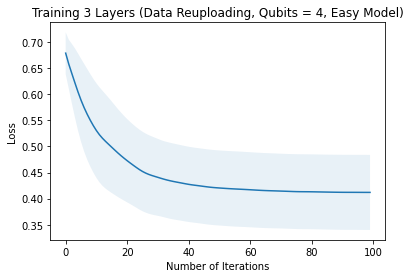

In [12]:
import matplotlib.pyplot as plt

stddevs =[]
averages =[]
sd = np.std(loss, axis=0)
av = np.average(loss, axis=0)
plt.plot(range(100), av)
plt.fill_between(range(100), av+np.array(sd), av-np.array(sd), alpha=0.1)
stddevs.append(sd)
averages.append(av)


plt.xlabel("Number of Iterations")
plt.ylabel("Loss")
plt.title("Training 3 Layers (Data Reuploading, Qubits = 4, Easy Model)")